In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('consolidated_genome_data.csv')

# Display basic info about the dataset
print(data.info())  # Overview of columns, data types, and non-null counts
print(data.head())  # Display first 5 rows of the dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73098 entries, 0 to 73097
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   assemblyAccession             53759 non-null  object 
 1   assemblyUnit                  53759 non-null  object 
 2   assignedMoleculeLocationType  53759 non-null  object 
 3   chrName                       53759 non-null  object 
 4   gcCount                       47464 non-null  float64
 5   gcPercent                     47464 non-null  float64
 6   genbankAccession              53759 non-null  object 
 7   length                        53759 non-null  float64
 8   refseqAccession               53759 non-null  object 
 9   role                          53759 non-null  object 
 10  sequenceName                  53759 non-null  object 
 11  ucscStyleName                 53759 non-null  object 
 12  unlocalizedCount              27084 non-null  float64
 13  S

In [6]:
# Calculate promoter length (end - start)
data['promoter_length'] = data['end'] - data['start']

# Avoid negative or zero promoter lengths by filtering
data = data[data['promoter_length'] > 0]

# Calculate TFBS density (assume GC_Content reflects TFBS influence)
data['tfbs_density'] = data['GC_Content'] / data['promoter_length']

# Handle missing or infinite values in TFBS density
data['tfbs_density'] = data['tfbs_density'].replace([np.inf, -np.inf], np.nan)
data = data.dropna(subset=['tfbs_density', 'Length_x', 'GC_Content'])

# Display the updated dataset info
print(data.info())
print(data[['promoter_length', 'tfbs_density']].head())


<class 'pandas.core.frame.DataFrame'>
Index: 53574 entries, 0 to 72911
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   assemblyAccession             53574 non-null  object 
 1   assemblyUnit                  53574 non-null  object 
 2   assignedMoleculeLocationType  53574 non-null  object 
 3   chrName                       53574 non-null  object 
 4   gcCount                       47464 non-null  float64
 5   gcPercent                     47464 non-null  float64
 6   genbankAccession              53574 non-null  object 
 7   length                        53574 non-null  float64
 8   refseqAccession               53574 non-null  object 
 9   role                          53574 non-null  object 
 10  sequenceName                  53574 non-null  object 
 11  ucscStyleName                 53574 non-null  object 
 12  unlocalizedCount              27036 non-null  float64
 13  Sequen

In [7]:
from sklearn.preprocessing import StandardScaler

# Standardize the numerical features
scaler = StandardScaler()
features_to_scale = ['tfbs_density', 'Length_x', 'GC_Content']
scaled_features = scaler.fit_transform(data[features_to_scale])

# Add scaled features back for clustering
data[['scaled_tfbs_density', 'scaled_length', 'scaled_gc_content']] = scaled_features

# Categorize TFBS density into low, medium, and high
data['tfbs_density_category'] = pd.qcut(data['tfbs_density'], q=3, labels=['Low', 'Medium', 'High'])

# Display the updated dataset
print(data[['tfbs_density', 'tfbs_density_category', 'scaled_tfbs_density']].head())


   tfbs_density tfbs_density_category  scaled_tfbs_density
0      0.003206                Medium            -0.299144
1      0.008292                  High            -0.254799
2      0.000316                   Low            -0.324345
3      0.000529                   Low            -0.322494
4      0.008912                  High            -0.249390


In [8]:
from sklearn.cluster import KMeans

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(scaled_features)

# Display the cluster centers and cluster assignments
print("Cluster Centers:")
print(kmeans.cluster_centers_)
print(data[['tfbs_density', 'tfbs_density_category', 'cluster']].head())


Cluster Centers:
[[-2.56729414e-01 -1.17713361e+00  5.28829044e-01]
 [ 2.69903370e+00 -6.81034832e-02  1.39994495e-03]
 [-2.71567284e-01  5.30054360e-01 -2.33962587e-01]]
   tfbs_density tfbs_density_category  cluster
0      0.003206                Medium        0
1      0.008292                  High        0
2      0.000316                   Low        2
3      0.000529                   Low        2
4      0.008912                  High        2


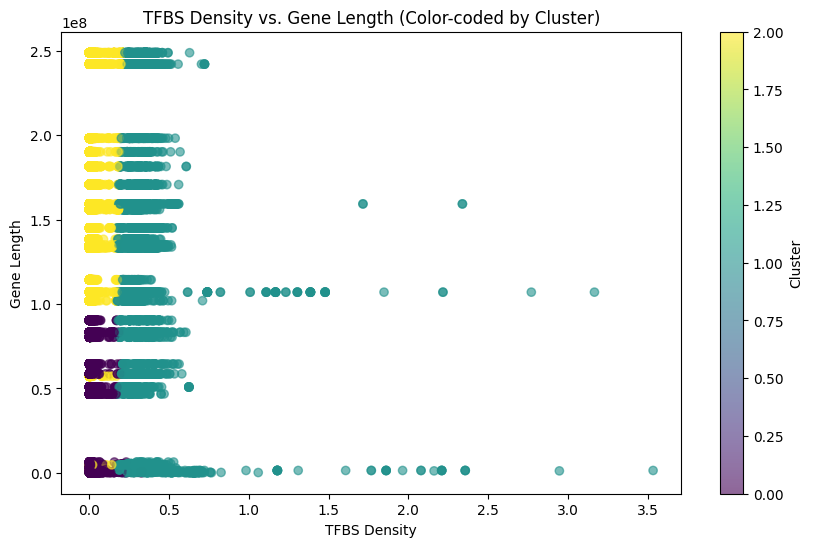

In [9]:
# Scatter plot: TFBS Density vs. Length_x
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['tfbs_density'], data['Length_x'], c=data['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('TFBS Density')
plt.ylabel('Gene Length')
plt.title('TFBS Density vs. Gene Length (Color-coded by Cluster)')
plt.show()


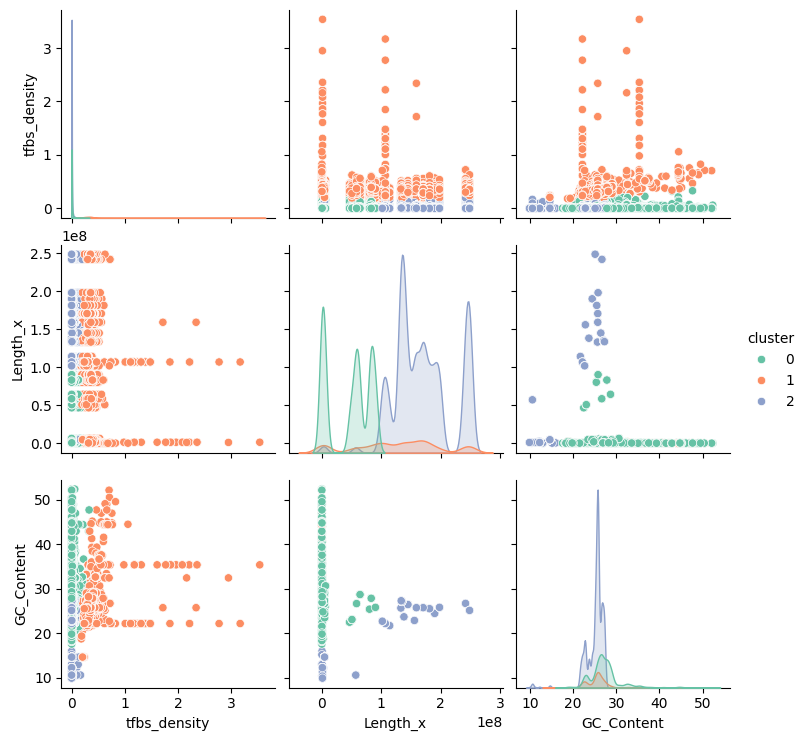

In [10]:
# Pair plot for visualizing relationships
sns.pairplot(data, vars=['tfbs_density', 'Length_x', 'GC_Content'], hue='cluster', palette='Set2')
plt.show()


/var/folders/6l/w2fcn1fx74n1phx_nvrsqn5c0000gn/T/ipykernel_4940/1716748169.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='tfbs_density', data=data, palette='Set2')


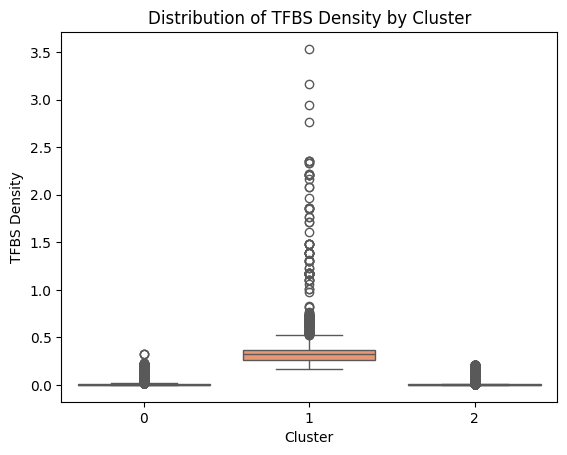

In [11]:
# Distribution of TFBS Density across clusters
sns.boxplot(x='cluster', y='tfbs_density', data=data, palette='Set2')
plt.title('Distribution of TFBS Density by Cluster')
plt.xlabel('Cluster')
plt.ylabel('TFBS Density')
plt.show()


cluster  Description                                                                                                                
0        NC_000019.10 Homo sapiens chromosome 19, GRCh38.p14 Primary Assembly                                                           2561
         NC_000017.11 Homo sapiens chromosome 17, GRCh38.p14 Primary Assembly                                                           2213
         NC_000016.10 Homo sapiens chromosome 16, GRCh38.p14 Primary Assembly                                                           1596
         NC_000020.11 Homo sapiens chromosome 20, GRCh38.p14 Primary Assembly                                                           1062
         NC_000022.11 Homo sapiens chromosome 22, GRCh38.p14 Primary Assembly                                                            887
         NC_000018.10 Homo sapiens chromosome 18, GRCh38.p14 Primary Assembly                                                            764
         NC_000021.9 

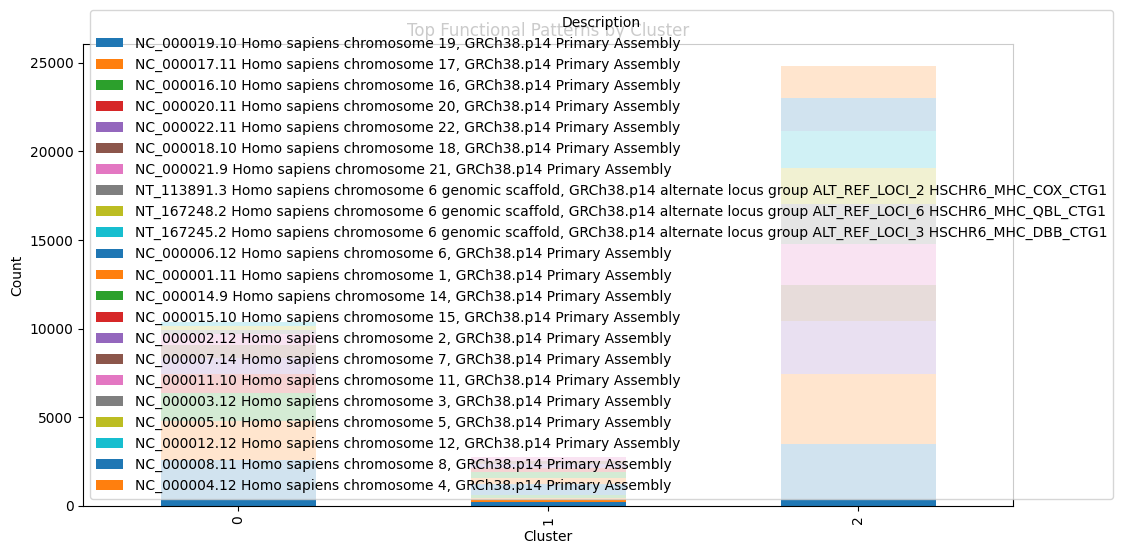

In [12]:
# Group by cluster and count the top descriptions
functional_summary = data.groupby('cluster')['Description'].value_counts().groupby(level=0).head(10)

# Display the functional summary
print(functional_summary)

# Plot functional patterns for each cluster (if needed)
functional_summary.unstack().plot(kind='bar', figsize=(12, 6), stacked=True)
plt.title('Top Functional Patterns by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


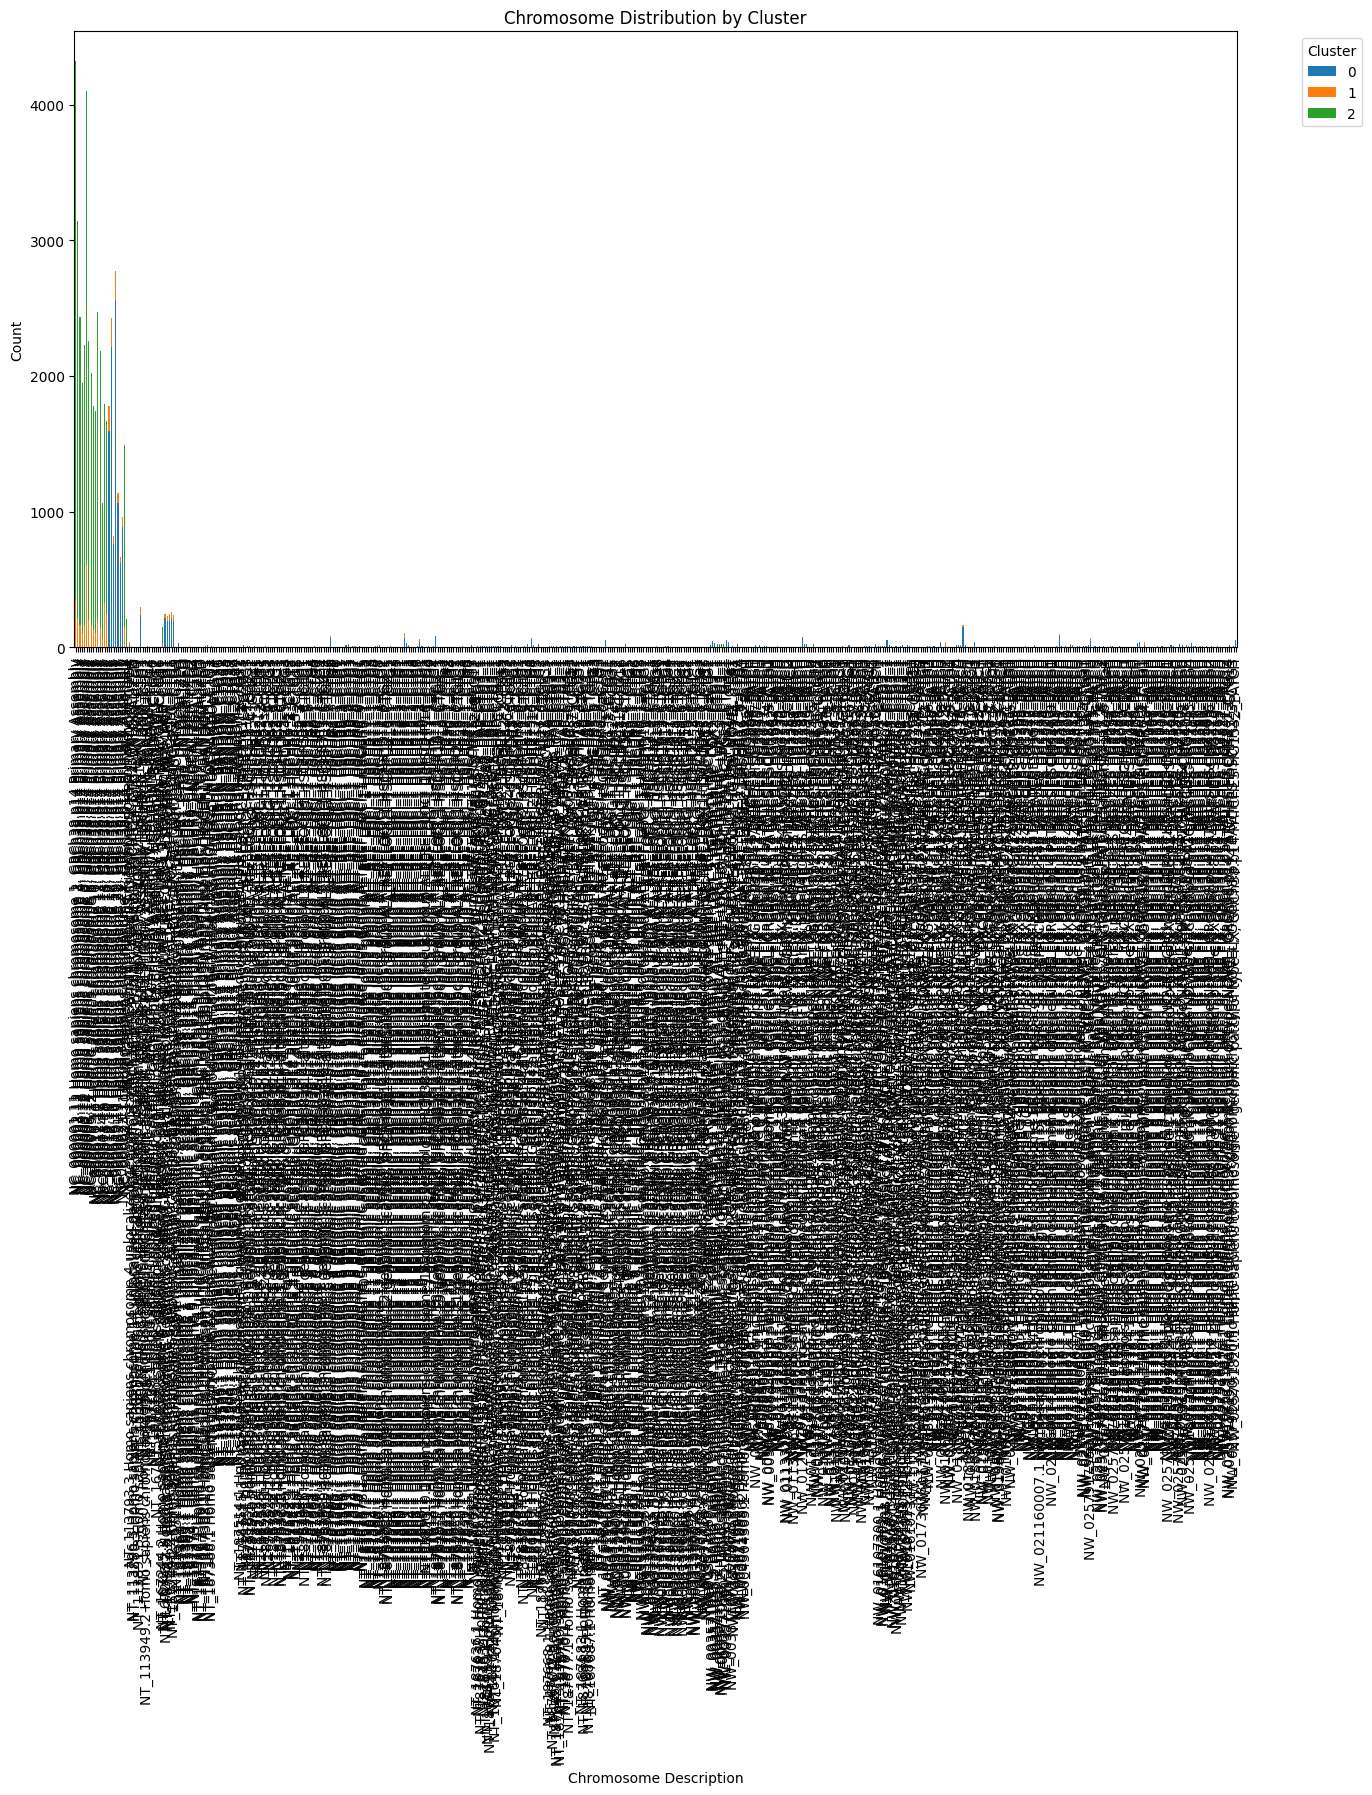

In [14]:
# Summarize chromosome counts per cluster
chromosome_distribution = data.groupby(['cluster', 'Description']).size().unstack(fill_value=0)

# Plot the chromosome distribution
chromosome_distribution.T.plot(kind='bar', figsize=(15, 8), stacked=True)
plt.title('Chromosome Distribution by Cluster')
plt.xlabel('Chromosome Description')
plt.ylabel('Count')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


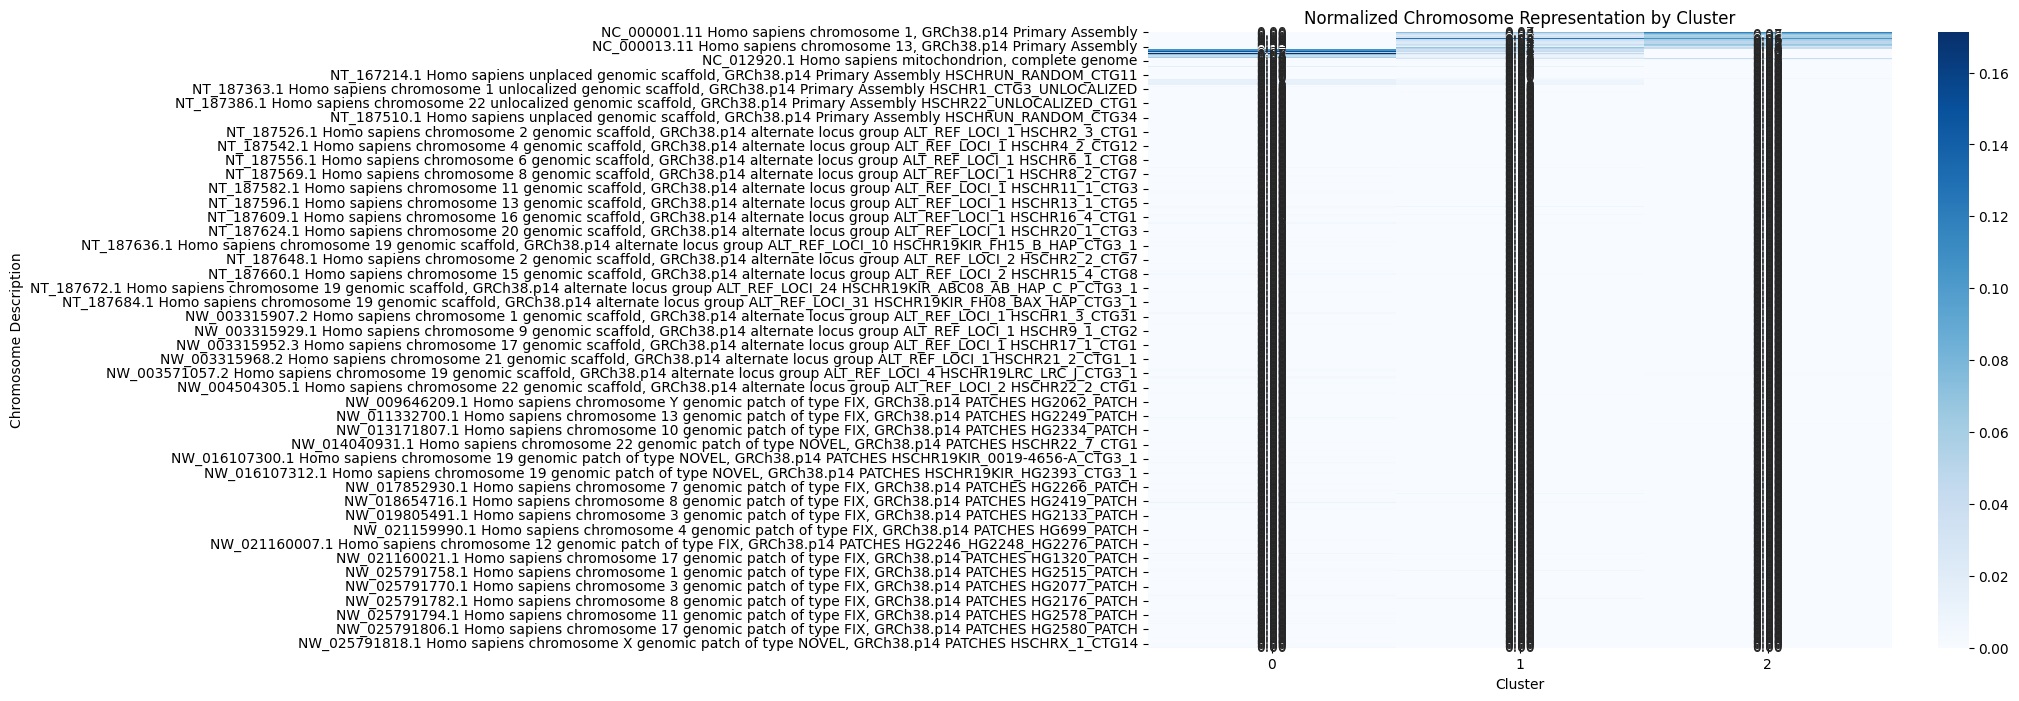

In [15]:
import seaborn as sns

# Normalize the chromosome counts per cluster
chromosome_distribution_norm = chromosome_distribution.div(chromosome_distribution.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(chromosome_distribution_norm.T, cmap='Blues', annot=True, fmt='.2f')
plt.title('Normalized Chromosome Representation by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Chromosome Description')
plt.show()


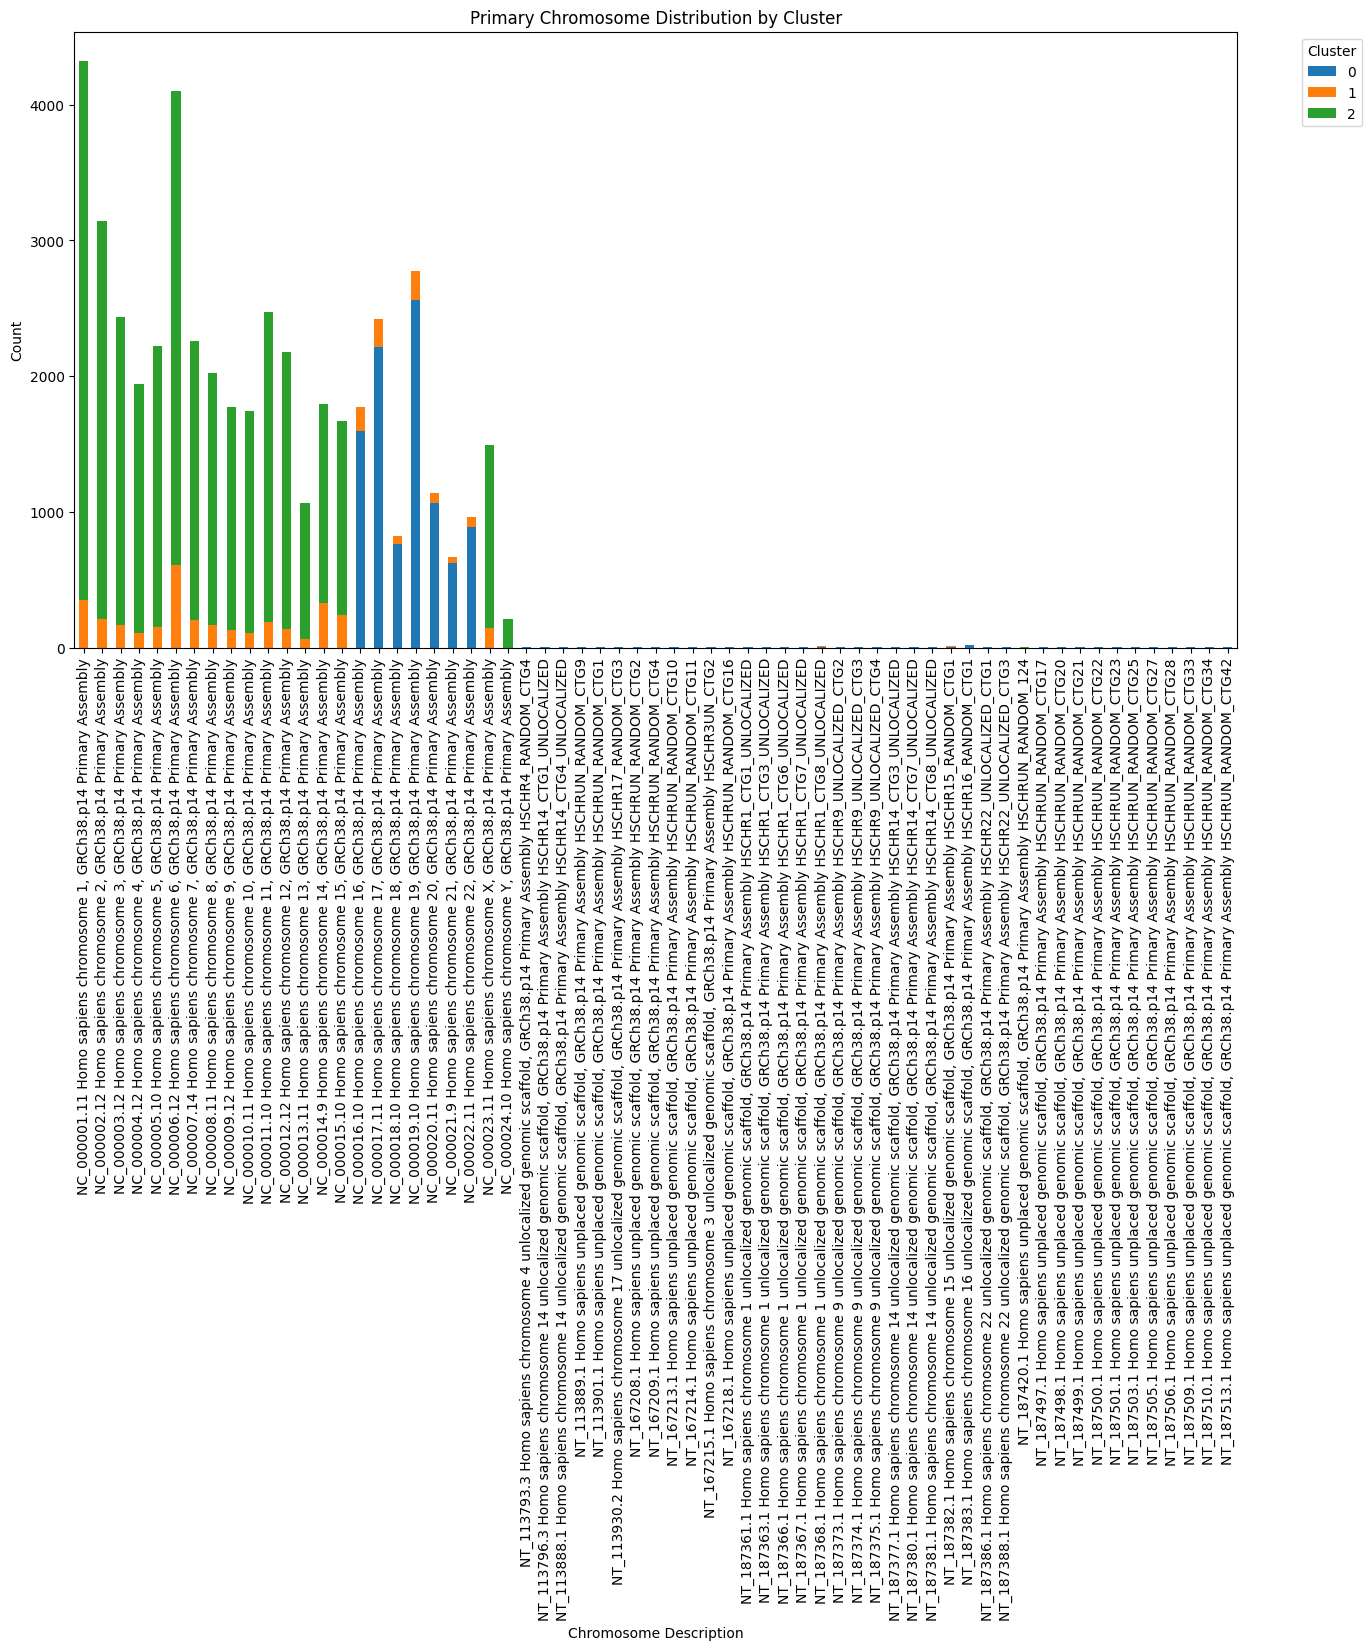

In [16]:
# Filter for primary chromosomes
primary_chromosomes = data[data['Description'].str.contains('Primary Assembly')]

# Regenerate the distribution by cluster for primary chromosomes
primary_chromosome_dist = primary_chromosomes.groupby(['cluster', 'Description']).size().unstack(fill_value=0)

# Plot the bar chart for primary chromosomes
primary_chromosome_dist.T.plot(kind='bar', figsize=(15, 8), stacked=True)
plt.title('Primary Chromosome Distribution by Cluster')
plt.xlabel('Chromosome Description')
plt.ylabel('Count')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [17]:
# Summarize top genes per cluster
top_genes_per_cluster = data.groupby('cluster')['Gene'].value_counts().groupby(level=0).head(10)
print(top_genes_per_cluster)


cluster  Gene           
0        KIR3DL2            47
         KIR3DL3            47
         KIR2DL4            41
         LOC101928804       39
         KIR2DL1            34
         KIR2DS4            33
         KIR3DL1            33
         KIR2DL3            31
         NCR1               18
         KIR2DS2            13
1        TRNAA-AGC           9
         LOC124900227        8
         MIR3135B            8
         MIR570              8
         SNORD117            8
         TRA-AGC1-1          8
         TRA-AGC2-1          8
         TRA-AGC2-2          8
         TRA-AGC6-1          8
         TRA-TGC1-1          8
2        BTNL2               9
         HCG23               9
         TSBP1-AS1           9
         ATP6V1G2-DDX39B     8
         DDX39B              8
         DHX16               8
         FLOT1               8
         GABBR1              8
         GNL1                8
         HCG4                8
Name: count, dtype: int64


In [19]:
# Save genes in each cluster to separate files
for cluster_id in data['cluster'].unique():
    cluster_genes = data[data['cluster'] == cluster_id]['Gene']
    cluster_genes.to_csv(f'cluster_{cluster_id}_genes.csv', index=False)


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('consolidated_genome_data.csv')

# Calculate promoter length
data['promoter_length'] = data['end'] - data['start']

# Calculate TFBS density
data['tfbs_density'] = data['GC_Content'] / data['promoter_length']

# Remove invalid or missing data
data = data[(data['tfbs_density'] > 0) & (data['Length_x'] > 0)]
data = data.dropna(subset=['tfbs_density', 'Length_x', 'GC_Content'])

# Check the prepared dataset
print(data[['Gene', 'tfbs_density', 'Length_x', 'GC_Content']].head())


       Gene  tfbs_density     Length_x  GC_Content
0      A1BG      0.003206   58617616.0   26.642153
1  A1BG-AS1      0.008292   58617616.0   26.642153
2      A1CF      0.000316  133797422.0   27.276444
3       A2M      0.000529  133275309.0   25.649470
4   A2M-AS1      0.008912  133275309.0   25.649470


In [21]:
# Categorize TFBS density into low, medium, and high
data['tfbs_density_category'] = pd.qcut(data['tfbs_density'], q=3, labels=['Low', 'Medium', 'High'])

# Standardize features for clustering
scaler = StandardScaler()
features = ['tfbs_density', 'Length_x', 'GC_Content']
scaled_features = scaler.fit_transform(data[features])

# Add scaled features for visualization
data[['scaled_tfbs_density', 'scaled_length', 'scaled_gc_content']] = scaled_features


In [22]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(scaled_features)

# Display cluster centers
print("Cluster Centers:")
print(kmeans.cluster_centers_)

# Summarize cluster characteristics
cluster_summary = data.groupby('cluster')[['tfbs_density', 'Length_x', 'GC_Content']].mean()
print(cluster_summary)


Cluster Centers:
[[-2.56729414e-01 -1.17713361e+00  5.28829044e-01]
 [ 2.69903370e+00 -6.81034832e-02  1.39994495e-03]
 [-2.71567284e-01  5.30054360e-01 -2.33962587e-01]]
         tfbs_density      Length_x  GC_Content
cluster                                        
0            0.008071  4.636173e+07   27.370860
1            0.347005  1.264753e+08   25.766664
2            0.006364  1.696796e+08   25.050560


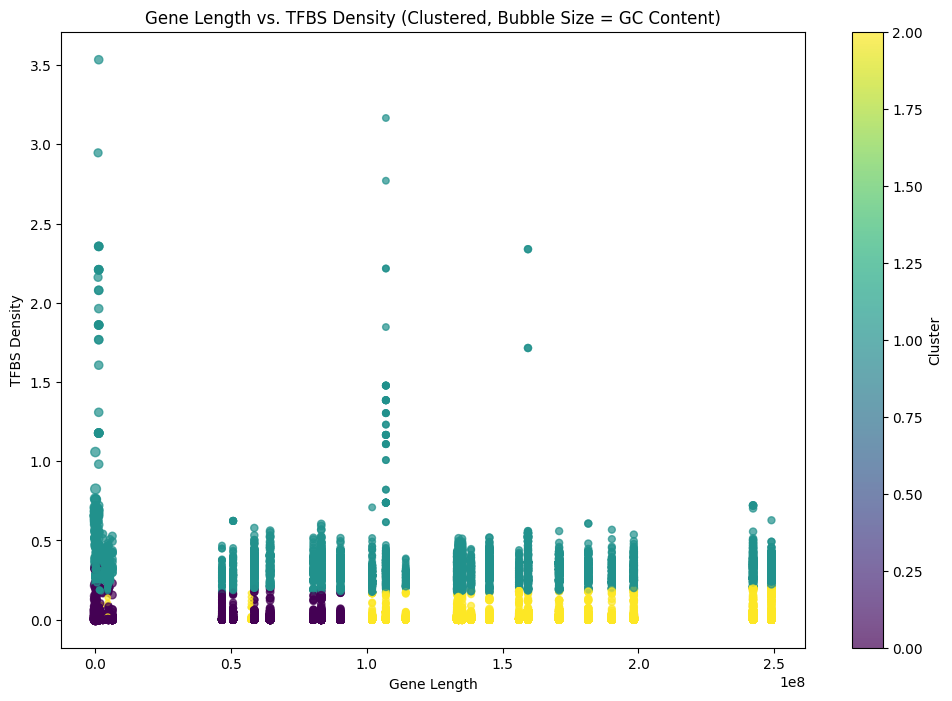

In [23]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    data['Length_x'], data['tfbs_density'], 
    c=data['cluster'], cmap='viridis', 
    s=data['GC_Content'], alpha=0.7
)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Gene Length')
plt.ylabel('TFBS Density')
plt.title('Gene Length vs. TFBS Density (Clustered, Bubble Size = GC Content)')
plt.show()


/var/folders/6l/w2fcn1fx74n1phx_nvrsqn5c0000gn/T/ipykernel_4940/1452796113.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  functional_summary = data.groupby(['cluster', 'tfbs_density_category'])['Description'].count().unstack()


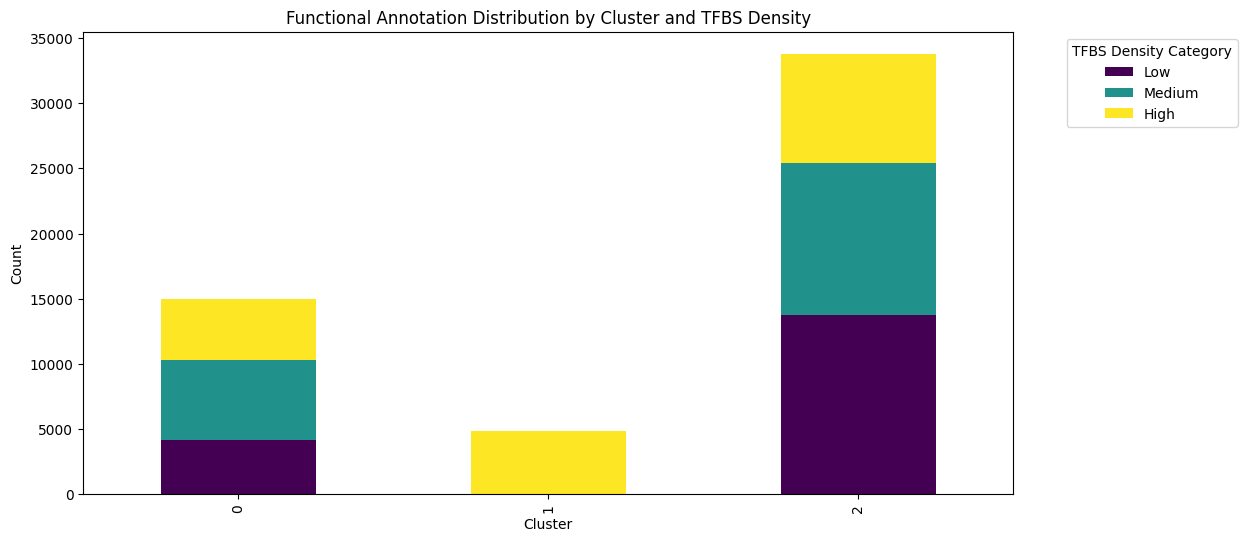

In [24]:
# Count functional annotations in clusters
functional_summary = data.groupby(['cluster', 'tfbs_density_category'])['Description'].count().unstack()

# Plot functional density distribution
functional_summary.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Functional Annotation Distribution by Cluster and TFBS Density')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='TFBS Density Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


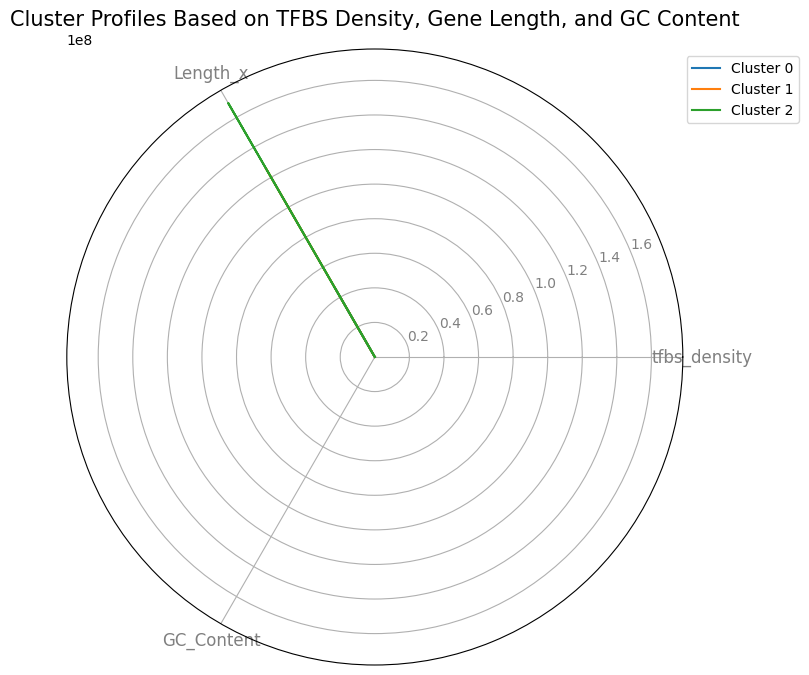

In [25]:
from math import pi

# Radar chart for cluster characteristics
cluster_data = cluster_summary.reset_index()
categories = list(cluster_summary.columns)

# Prepare data for radar plot
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

plt.figure(figsize=(8, 8))

for i, row in cluster_data.iterrows():
    values = row[categories].values.flatten().tolist()
    values += values[:1]
    plt.polar(angles, values, label=f'Cluster {int(row["cluster"])}')

plt.fill(angles, values, alpha=0.25)
plt.xticks(angles[:-1], categories, color='grey', size=12)
plt.yticks(color='grey', size=10)
plt.title('Cluster Profiles Based on TFBS Density, Gene Length, and GC Content', size=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()
